## Coral-Age Labels to 3 Class

Coral-Age는 다른 transforms 로 학습시켰다는 걸 잊으면 안된다.

> 귀찮으니깐 다시 원래 transforms 쓰기로 함. 여기서만 테스트 다르게

In [1]:
import os

os.chdir('/opt/ml/P-Stage/1-STAGE/')

from PIL import Image

import wandb
import torch
import numpy as np
import pandas as pd
import torch.nn as nn

import matplotlib.pyplot as plt
from sklearn.metrics import (
    f1_score,
    recall_score,
    accuracy_score,
    precision_score,
    confusion_matrix,
)

from config import get_args
from train import get_label_fn
from prepare import get_dataloader, get_classes
from metrics import (
    change_2d_to_1d,
    tensor_to_numpy,
    calculate_18class,
    tensor_images_to_numpy_images,
    get_num_classes
)
from coral_pytorch.dataset import proba_to_label, levels_from_labelbatch

from log_helper import (
    log_f1_and_acc_scores,
    log_confusion_matrix,
    log_confusion_matrix_by_images,
)


def get_all_datas(args, model, dataloader, argmax=True):
    model.eval()

    all_images = torch.tensor([]).to(args.device)
    all_labels = torch.tensor([]).to(args.device)
    all_preds = torch.tensor([]).to(args.device)
    num_class = get_num_classes(args)
    get_labels = get_label_fn(args)

    with torch.no_grad():
        for idx, (images, labels) in enumerate(dataloader):
            all_labels = torch.cat((all_labels, labels.to(args.device)))
            images, labels = images.to(args.device), labels.to(args.device)
            
            if args.loss_metric == 'coral_loss':
                labels = levels_from_labelbatch(labels, num_classes=num_class)

            preds = model(images)

            preds = get_labels(preds)
            preds = change_2d_to_1d(preds)

            all_images = torch.cat((all_images, images))
            all_preds = torch.cat((all_preds, preds))

    return all_images, all_labels, all_preds

In [2]:
args = get_args()

args.train_key = 'age-coral'
args.loss_metric = 'coral_loss'
args.device = "cuda:0" if torch.cuda.is_available() else "cpu"

args.valid_size=0.2
args.test=False

args

Namespace(age_model='/opt/ml/weights/age.pt', aug_keys='CJ,FancyPCA', batch_size=64, data_dir='/opt/ml/input/data/train', device='cuda:0', epochs=25, gender_model='/opt/ml/weights/gender.pt', image_size=224, inf_filename='valid', loss_metric='coral_loss', lr=0.001, mask_model='/opt/ml/weights/mask.pt', model_path='/opt/ml/weights/', model_save=True, optimizer='adam', seed=42, test=False, train_key='age-coral', use_only_mask=False, valid_size=0.2, workers=2)

In [3]:
model_path = '/opt/ml/weights/age-coral-04060448-prime-sweep-2.pt'
model = torch.load(model_path)

In [4]:
# Get Album Transforms
from prepare import get_album_transforms, MaskDataSet
from torch.utils.data import DataLoader

_, transform = get_album_transforms(args)
dataset = MaskDataSet(args, is_train=False, transform=transform)
dataloader = DataLoader(
    dataset, 
    shuffle=False, 
    pin_memory=True, 
    num_workers=2, 
    batch_size=args.batch_size)

In [5]:
_, labels, preds = get_all_datas(args, model, dataloader)

In [6]:
preds.unique()

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
        28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41.,
        42.], device='cuda:0')

In [7]:
labels[:10], preds[:10]

(tensor([33., 33., 33., 33., 33., 33., 33., 38., 38., 38.], device='cuda:0'),
 tensor([33., 38., 34., 34., 36., 33., 33., 39., 42., 39.], device='cuda:0'))

In [8]:
labels, preds = tensor_to_numpy(labels), tensor_to_numpy(preds)

In [9]:
labels[:10], preds[:10]

(array([33., 33., 33., 33., 33., 33., 33., 38., 38., 38.], dtype=float32),
 array([33., 38., 34., 34., 36., 33., 33., 39., 42., 39.], dtype=float32))

In [10]:
def get_age_class(num):
    num += 18
    if num < 30:
        return 0
    if num < 60:
        return 1
    return 2

def change_classes_to_3class(labels, preds):
    labels3 = np.empty_like(labels).astype(np.uint8)
    preds3 = np.empty_like(preds).astype(np.uint8)
    
    for idx, (l, p) in enumerate(zip(labels, preds)):
        labels3[idx] = get_age_class(l)
        preds3[idx] = get_age_class(p)
    
    return labels3, preds3

In [11]:
labels, preds = change_classes_to_3class(labels, preds)

In [12]:
labels.shape, preds.shape

((3780,), (3780,))

In [13]:
set(labels), set(preds)

({0, 1, 2}, {0, 1, 2})

In [14]:
args.train_key = "age"

log_f1_and_acc_scores(args, labels, preds)

,0 f1,0 pr,0 re,0 acc,1 f1,1 pr,1 re,1 acc,2 f1,2 pr,2 re,2 acc
age,0.962102,1.0,0.926972,0.926972,0.92589,1.0,0.862006,0.862006,0.717822,1.0,0.559846,0.559846


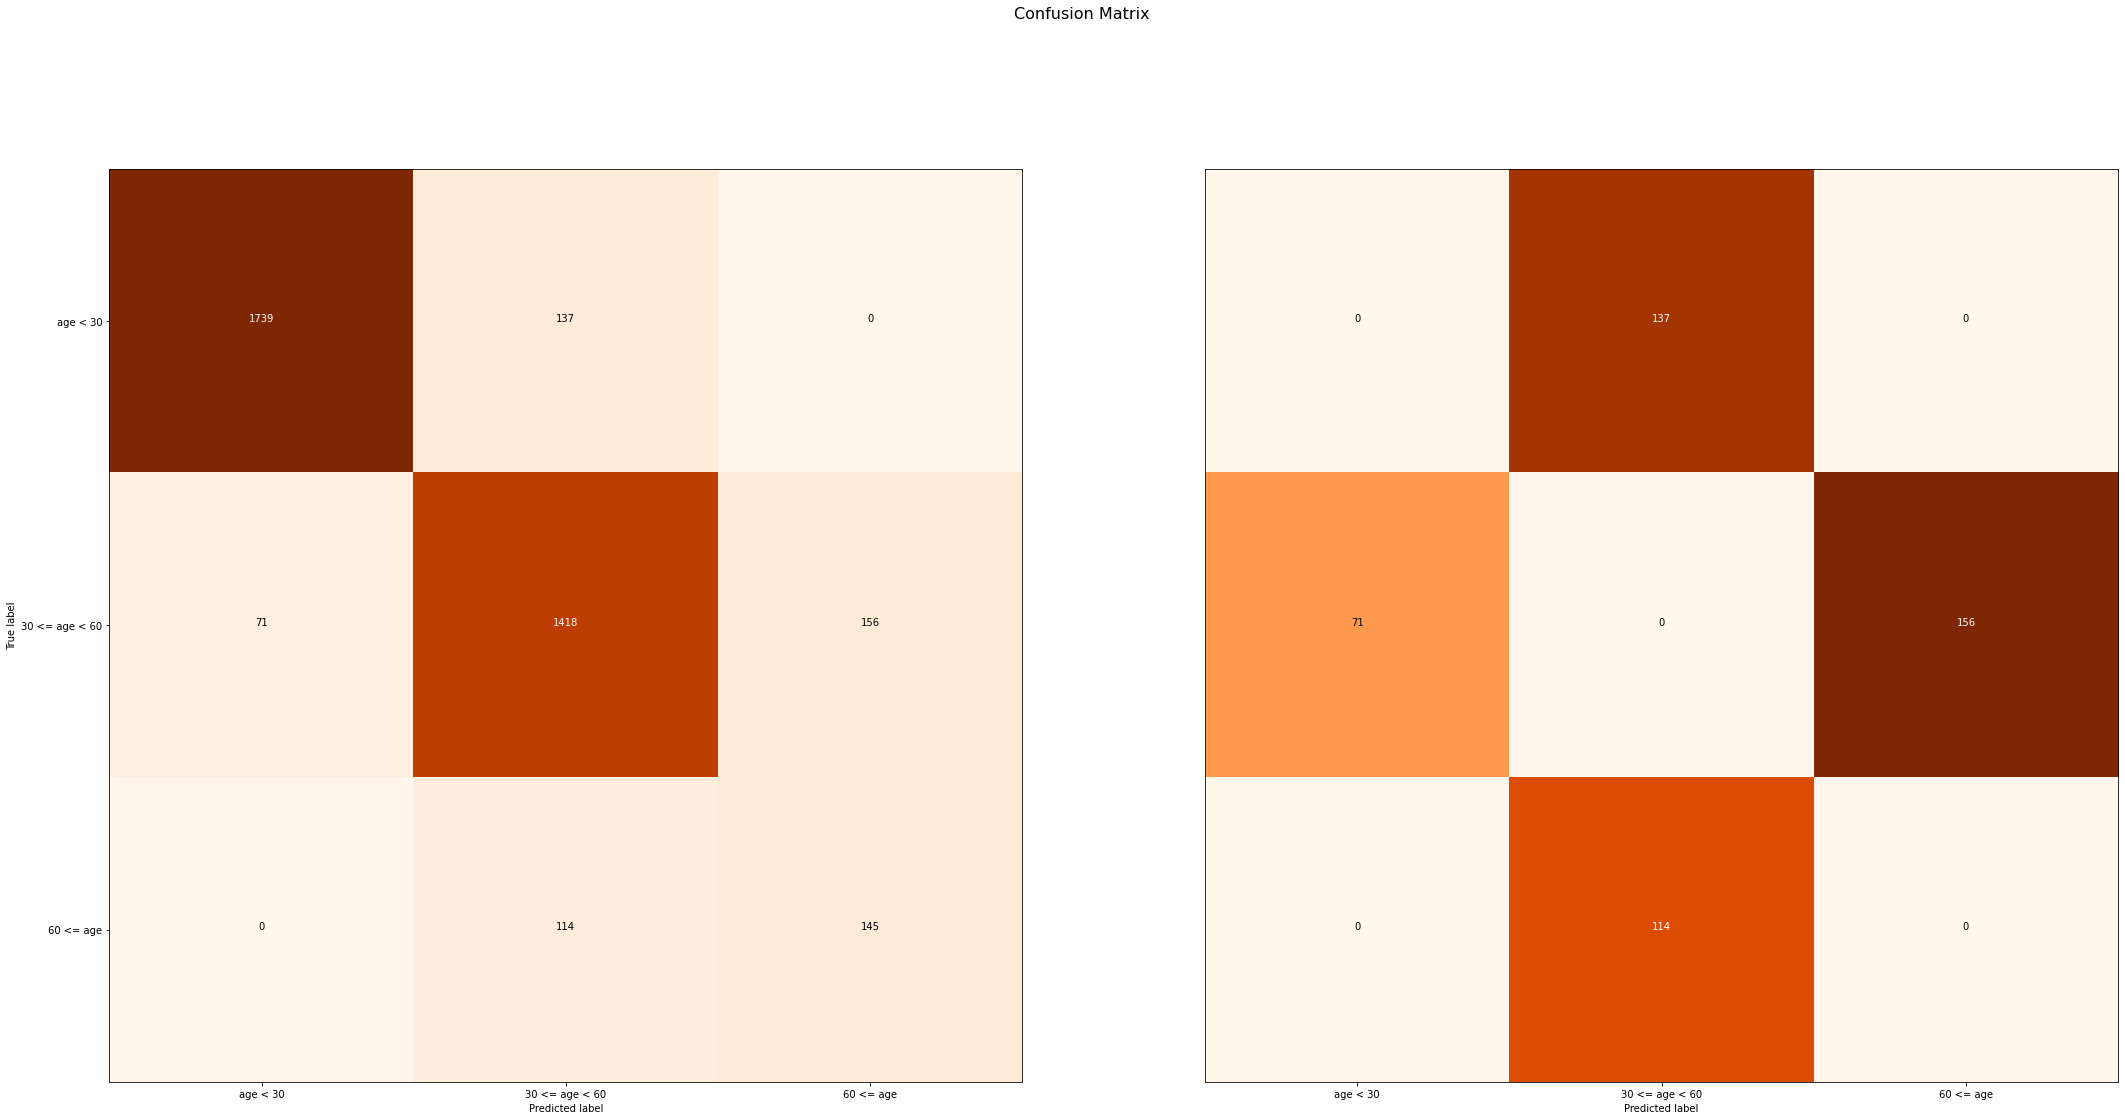

In [15]:
fig = log_confusion_matrix(args, labels, preds)